# PCA of EEG Features (Dortmund Dataset)
This notebook describes the process of applying PCA to EEG-derived features, exploring dimensionality reduction, and preparing data for clustering.

- Objective: Reduce high-dimensional EEG features to a lower-dimensional space to explore participant variability.
- Dataset: Dortmund dataset (608 participants, multiple EEG features).
- Goals:
  1. Understand structure of the features.
  2. Perform PCA for dimensionality reduction.
  3. Explore variance explained by principal components.
  4. Prepare data for clustering and visualization.

## Load Data
Load the Dortmund dataset and inspect the first few rows.

In [1]:
import pandas as pd
import numpy as np

dort = pd.read_csv("./dataset/Dortmund_features.csv", index_col=0)  # Keep subject IDs as index!
age_sex_dort = pd.read_csv("./dataset/Dortmund_age&sex.csv", index_col=0)
# Extract age and sex
age_dort = age_sex_dort['age'].values
sex_dort = age_sex_dort['sex'].values

lemon = pd.read_csv("./dataset/Lemon_features.csv", index_col=0)  # Keep subject IDs as index!
age_sex_lemon = pd.read_csv("./dataset/Lemon_age&sex.csv", index_col=0)
# Extract age and sex
age_lemon = age_sex_lemon['age_group'].values # note ages are ranges in Lemon
sex_lemon = age_sex_lemon['sex'].values

## Exploratory Data Analysis
- Preview first few rows and numeric columns.
- Check for missing values.
- Examine feature distributions.

In [2]:
# Print dataset shapes
print(f"Dortmund_features.csv shape: {dort.shape}")
print(f"LEMON_features.csv shape: {lemon.shape}\n")

dort_cols = set(dort.columns)
lemon_cols = set(lemon.columns)

print("Features only in Dortmund:")
print(dort_cols - lemon_cols, "\n")

print("Features only in LEMON:")
print(lemon_cols - dort_cols, "\n")


Dortmund_features.csv shape: (600, 147)
LEMON_features.csv shape: (190, 147)

Features only in Dortmund:
set() 

Features only in LEMON:
set() 



All features are shared in Dortmund and Lemon

1. Scatter Plot of First Two Raw Features


Plotting the first two numeric features:
Feature 1: nl_rqa mean diag length
Feature 2: kurtosis_amp_theta



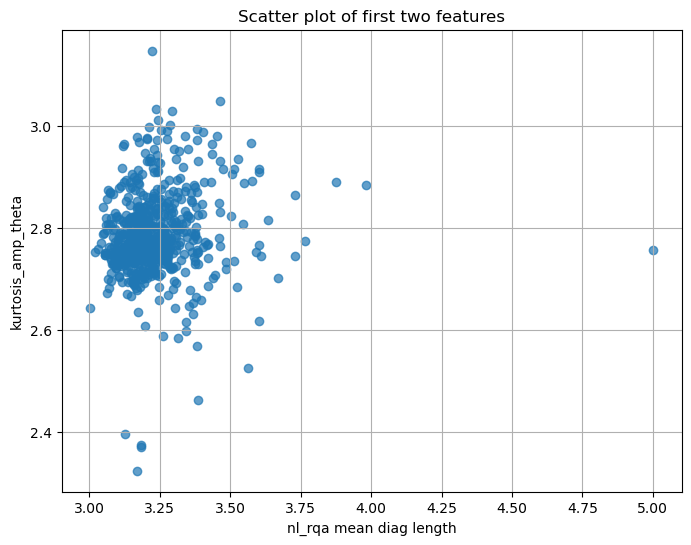

In [3]:
import matplotlib.pyplot as plt

# Select only numeric columns (exclude IDs or non-numeric)
numeric_data = dort.select_dtypes(include=['float64', 'int64'])
dort_numeric = numeric_data.values

# Define features (all numeric columns)
features = dort_numeric  # shape: (participants, features)

# Print what we are plotting
print("Plotting the first two numeric features:")
print(f"Feature 1: {numeric_data.columns[0]}")
print(f"Feature 2: {numeric_data.columns[1]}\n")

# Scatter plot of first two features
plt.figure(figsize=(8,6))
plt.scatter(features[:, 0], features[:, 1], alpha=0.7)
plt.xlabel(numeric_data.columns[0])
plt.ylabel(numeric_data.columns[1])
plt.title("Scatter plot of first two features")
plt.grid(True)
plt.show()


2. Feature-Age/Sex Relationship
-   **Age** — plotted using scatter plots  
-   **Sex** — plotted using boxplots (female vs male)

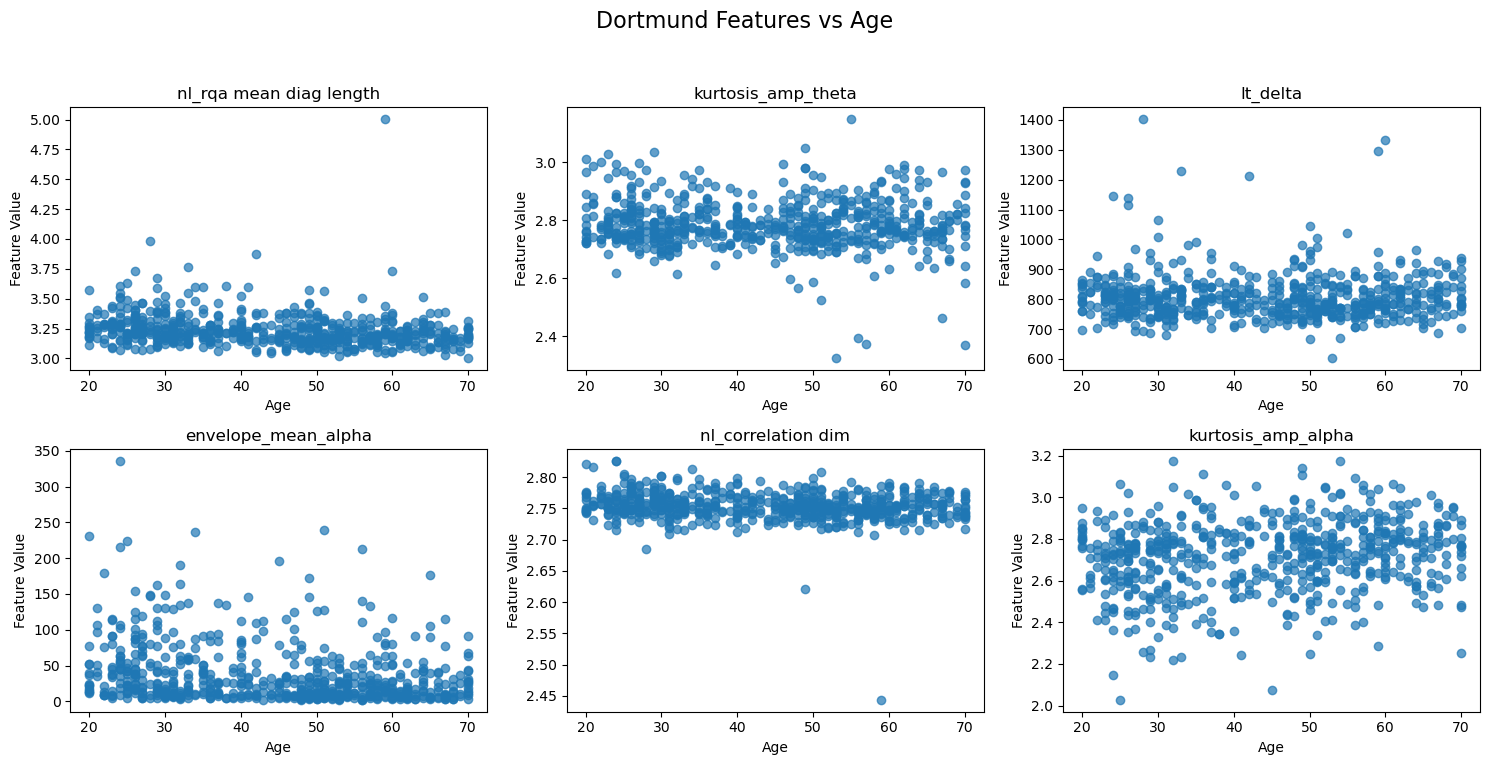

/var/folders/8g/xxs_fk6n0wx22j3lv0pzth1m0000gn/T/ipykernel_40287/479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
/var/folders/8g/xxs_fk6n0wx22j3lv0pzth1m0000gn/T/ipykernel_40287/479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
/var/folders/8g/xxs_fk6n0wx22j3lv0pzth1m0000gn/T/ipykernel_40287/479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dor

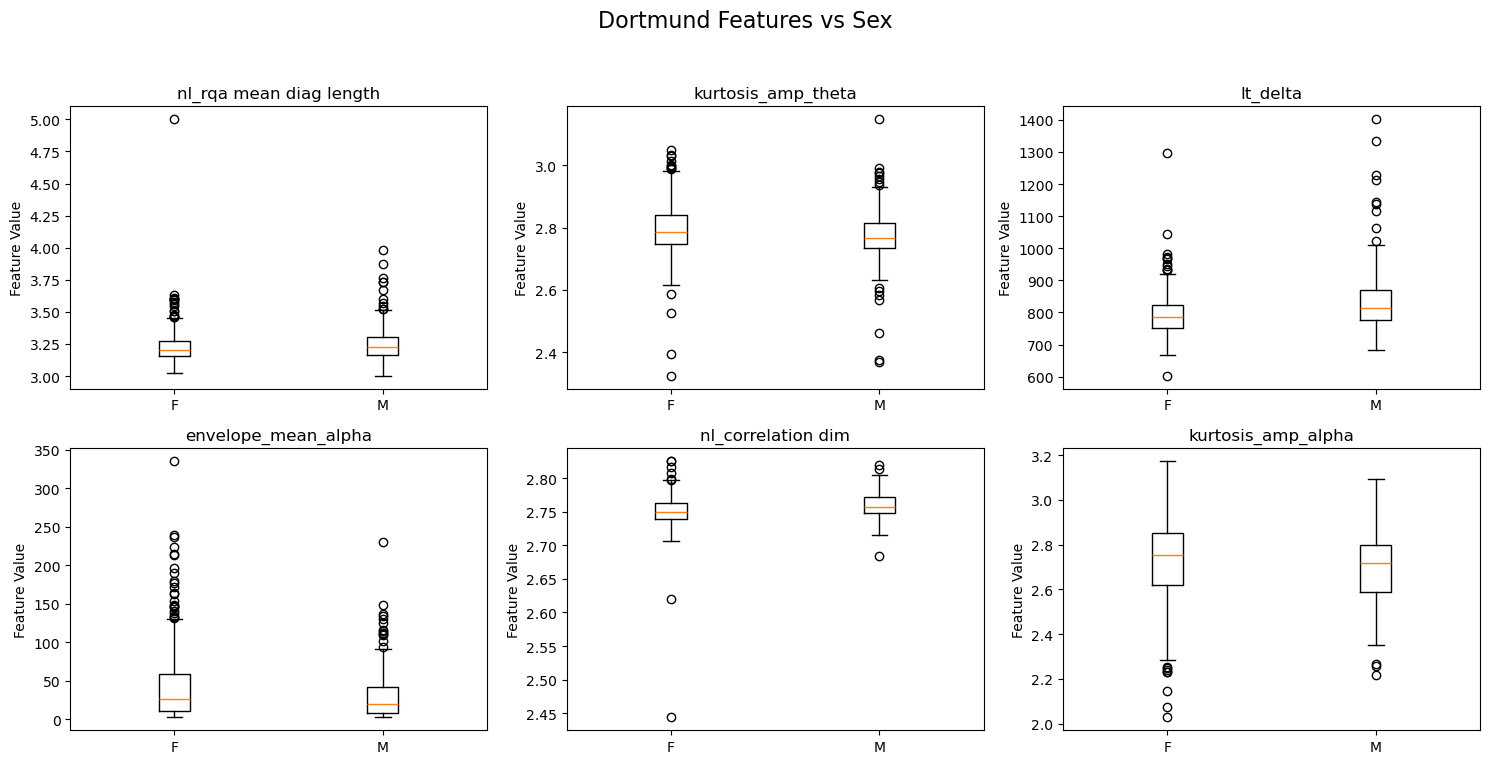

In [4]:
# Numeric Dortmund features
dort_numeric = dort.select_dtypes(include=['float64', 'int64'])
num_features_to_plot = 6

# -------------------------
# Plot features vs Age
# -------------------------
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i in range(num_features_to_plot):
    axes[i].scatter(age_dort, dort_numeric.iloc[:, i], alpha=0.7)
    axes[i].set_title(dort_numeric.columns[i])
    axes[i].set_xlabel("Age")
    axes[i].set_ylabel("Feature Value")

plt.suptitle("Dortmund Features vs Age", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# -------------------------
# Plot features vs Sex
# -------------------------
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i in range(num_features_to_plot):
    axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
                    labels=['F','M'])
    axes[i].set_title(dort_numeric.columns[i])
    axes[i].set_ylabel("Feature Value")

plt.suptitle("Dortmund Features vs Sex", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Principal Component Analysis (PCA)
- Reduce dimensionality to an optimal number of PCs for clustering while optionally visualizing in 2D.
- Examine explained variance, singular values, and component loadings to understand feature contributions.


1. Standardize Features
- PCA is sensitive to scale, so all numeric features are standardized to mean = 0 and variance = 1 before PCA.

2. Optimal PCA Computation
- Compute full PCA and determine the minimum number of PCs needed to reach a threshold variance (default 80%).
- Plot cumulative explained variance and scree plot to visualize the variance captured by each component.

3.  PCA Component Loadings & Transformed Data
- Loadings indicate how strongly each original feature contributes to each principal component.
- Transformed PCA data (scores) are used for clustering.
- Optionally export loadings and PCA-transformed dataset for further analysis.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def run_optimal_pca(data, threshold=0.8, dataset_name="Dataset", export=False):
    """
    Standardizes data, computes full PCA, finds optimal PCs using cumulative variance,
    plots PCA results, and returns PCA-transformed data and components.
    
    Parameters:
        data : pandas DataFrame (numeric)
        threshold : float, e.g. 0.8 for 80% variance
        dataset_name : str (used in plot titles)
        
    Returns:
        pca_optimal_components : np.array (PCA-transformed data)
        pca_model_optimal : PCA object fitted with optimal n_components
        num_pcs_threshold : int (optimal number of PCs)
        explained_variance_full : np.array (all PCs variance)
        components_optimal : np.array (loadings)
    """

    # 1. Standardize
    scaled = StandardScaler().fit_transform(data)

    # 2. Full PCA
    pca_full = PCA()
    pca_full.fit(scaled)

    explained_variance_full = pca_full.explained_variance_ratio_
    cumulative = np.cumsum(explained_variance_full)

    # 3. Determine optimal PCs
    num_pcs_threshold = np.argmax(cumulative >= threshold) + 1

    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Cumulative plot
    axes[0].plot(range(1, len(cumulative)+1), cumulative*100, marker='o')
    axes[0].axvline(num_pcs_threshold, color='r', linestyle='--',
                    label=f'{int(threshold*100)}% at PC{num_pcs_threshold}')
    axes[0].set_title(f"{dataset_name}: Cumulative Explained Variance")
    axes[0].set_xlabel("Number of Principal Components")
    axes[0].set_ylabel("Cumulative Explained Variance (%)")
    axes[0].legend()
    axes[0].grid(True)

    # Scree plot
    axes[1].plot(range(1, len(explained_variance_full)+1),
                 explained_variance_full*100, marker='o', alpha=0.7)
    axes[1].axhline(explained_variance_full[num_pcs_threshold-1]*100,
                    color='r', linestyle='--',
                    label=f'PC{num_pcs_threshold} variance')
    axes[1].set_title(f"{dataset_name}: Scree Plot")
    axes[1].set_xlabel("Principal Component")
    axes[1].set_ylabel("Explained Variance (%)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # 4. Run optimal PCA
    pca_optimal = PCA(n_components=num_pcs_threshold)
    transformed = pca_optimal.fit_transform(scaled)

    # --- Printing ---
    print(f"\n=== {dataset_name}: Optimal PCA Summary ===")
    print(f"Optimal number of PCs for {int(threshold*100)}% variance: {num_pcs_threshold}")
    print(f"Variance explained by PC1: {explained_variance_full[0]*100:.2f}%")
    print(f"Total variance explained by {num_pcs_threshold} PCs: {cumulative[num_pcs_threshold-1]*100:.2f}%\n")

    print("\n=== Explained Variance of Optimal PCs ===")
    for i, v in enumerate(pca_optimal.explained_variance_ratio_, start=1):
        print(f"PC{i}: {v*100:.2f}%")

    print("\n=== First 5 Singular Values ===")
    print(pca_optimal.singular_values_[:5])

    print("\n=== PCA Loadings (First 3 Features Per PC) ===")
    for i, pc in enumerate(pca_optimal.components_, start=1):
        print(f"PC{i}: {pc[:3]}")


    # --------------------------- #
    # 5. Optional export to CSV
    # --------------------------- #
    # --------------------------- #
    # 5. Optional export to CSV
    # --------------------------- #
    if export:
        # --- PCA Components (Loadings) ---
        # Rows = PCs, Columns = original features
        # This shows HOW MUCH each original feature contributes to each PC
        loadings_df = pd.DataFrame(
            pca_optimal.components_,
            columns=data.columns,
            index=[f"PC{i+1}" for i in range(num_pcs_threshold)]
        )
        loadings_path = f"dataset/{dataset_name}_pca_loadings.csv"
        loadings_df.to_csv(loadings_path, index=True)

        # --- PCA Transformed Data ---
        # Rows = Subjects, Columns = PCs
        # This is what you use for CLUSTERING
        transformed_df = pd.DataFrame(
            transformed,
            index=data.index, # Keep original subject IDs!
            columns=[f"PC{i+1}" for i in range(num_pcs_threshold)]
        )
        transformed_path = f"dataset/{dataset_name}_pca.csv"
        transformed_df.to_csv(transformed_path, index=True)

        print(f"\n✓ Exported loadings to:     {loadings_path}")
        print(f"✓ Exported PCA scores to:   {transformed_path}")
        print(f"  Subject IDs preserved: {transformed_df.index[:3].tolist()}... (first 3)")

    return transformed, pca_optimal, num_pcs_threshold, explained_variance_full, pca_optimal.components_


OPTIMAL PCA (DORTMUND DATASET):

data_pca      → The PCA-transformed dataset (participants × optimal PCs).
                These are the coordinates of each subject in PCA space.

data_model    → The fitted PCA model object.
                Contains components_, explained_variance_ratio_, singular_values_, etc.

data_nPC      → The optimal number of principal components selected automatically.
                Determined by reaching the cumulative variance threshold (e.g., 80%).

data_var      → Explained variance ratio of each selected PC.
                Tells you how much variance each principal component captures.

data_loadings → PCA loadings (components): contribution of each original feature to each PC.
                Shape = (nPC × n_features). Used for interpretation and clustering.

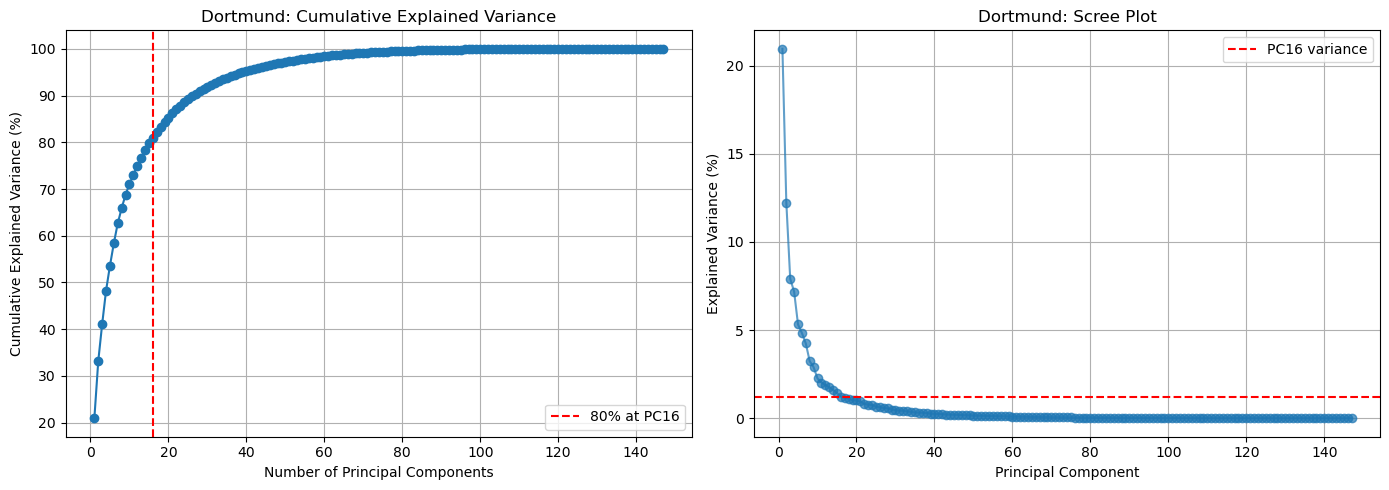


=== Dortmund: Optimal PCA Summary ===
Optimal number of PCs for 80% variance: 16
Variance explained by PC1: 20.95%
Total variance explained by 16 PCs: 80.96%


=== Explained Variance of Optimal PCs ===
PC1: 20.95%
PC2: 12.23%
PC3: 7.91%
PC4: 7.18%
PC5: 5.32%
PC6: 4.83%
PC7: 4.24%
PC8: 3.23%
PC9: 2.90%
PC10: 2.26%
PC11: 2.02%
PC12: 1.89%
PC13: 1.76%
PC14: 1.61%
PC15: 1.43%
PC16: 1.22%

=== First 5 Singular Values ===
[135.92426733 103.85380041  83.50298096  79.57932546  68.4821475 ]

=== PCA Loadings (First 3 Features Per PC) ===
PC1: [ 0.07755219  0.03162876 -0.02748839]
PC2: [-0.17531186 -0.01302007 -0.12494593]
PC3: [-0.05803032 -0.0689393  -0.13057813]
PC4: [-0.01288435  0.02623791 -0.09575204]
PC5: [ 0.06349979 -0.12897317 -0.02706782]
PC6: [0.03376791 0.01408716 0.08135568]
PC7: [0.08087157 0.08480302 0.04429539]
PC8: [-0.07384965  0.09187775 -0.09995531]
PC9: [0.00616762 0.06771318 0.07692679]
PC10: [-0.02052963 -0.11686879 -0.03655762]
PC11: [0.00501901 0.23644117 0.10380225]
P

In [6]:
dort_numeric = dort.select_dtypes(include=['float64', 'int64'])
dort_pca, dort_model, dort_nPC, dort_var, dort_loadings = run_optimal_pca(
    dort_numeric,
    threshold=0.80,
    dataset_name="Dortmund",
    export=True
)

OPTIMAL PCA (LEMON DATASET):

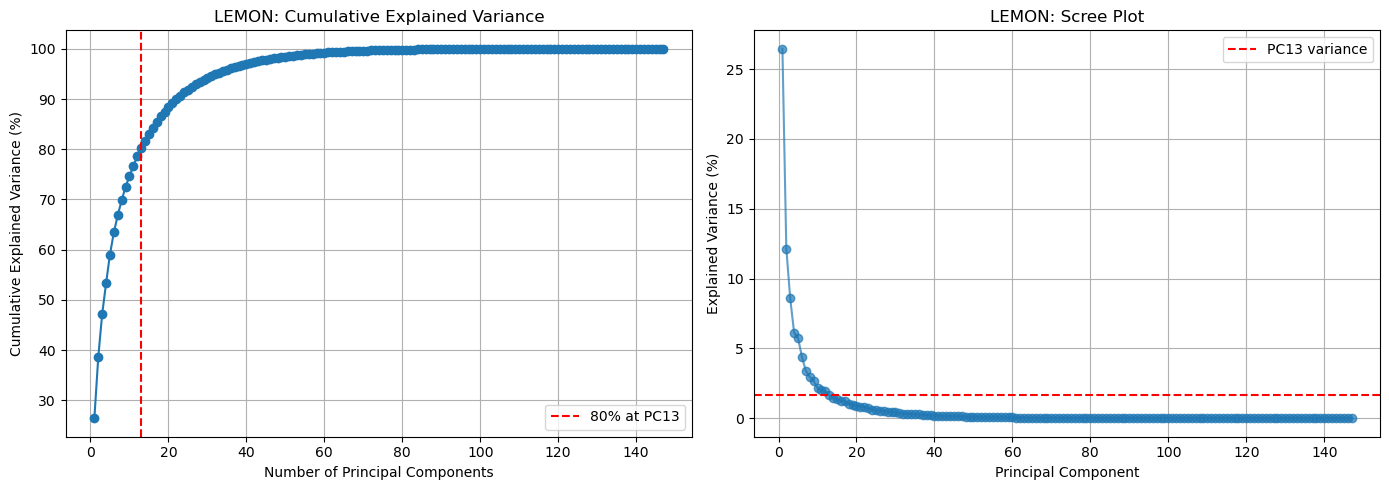


=== LEMON: Optimal PCA Summary ===
Optimal number of PCs for 80% variance: 13
Variance explained by PC1: 26.45%
Total variance explained by 13 PCs: 80.24%


=== Explained Variance of Optimal PCs ===
PC1: 26.45%
PC2: 12.15%
PC3: 8.57%
PC4: 6.13%
PC5: 5.75%
PC6: 4.41%
PC7: 3.40%
PC8: 2.96%
PC9: 2.68%
PC10: 2.15%
PC11: 2.01%
PC12: 1.93%
PC13: 1.64%

=== First 5 Singular Values ===
[85.9498367  58.24597055 48.9346571  41.37887684 40.0681235 ]

=== PCA Loadings (First 3 Features Per PC) ===
PC1: [0.1183683  0.00626448 0.06426968]
PC2: [-0.01681211  0.05213916 -0.10845719]
PC3: [ 0.04190047 -0.01404165  0.09092072]
PC4: [-0.00944458  0.11810503  0.12506928]
PC5: [0.15848921 0.02815616 0.03572152]
PC6: [-0.0697668  -0.02414548 -0.02613632]
PC7: [ 0.03277971  0.0790457  -0.14885173]
PC8: [-0.02086367 -0.14332598  0.05058819]
PC9: [ 0.00972326  0.17819356 -0.03012205]
PC10: [ 0.07506859 -0.07097608  0.02327065]
PC11: [-0.00868137 -0.18580685 -0.04964539]
PC12: [ 0.00321458 -0.22565086  0.10436

In [7]:
lemon_numeric = lemon.select_dtypes(include=['float64', 'int64'])
lemon_pca, lemon_model, lemon_nPC, lemon_var, lemon_loadings = run_optimal_pca(
    lemon_numeric,
    threshold=0.8,
    dataset_name="LEMON",
    export=True
)


## PCA Stability Analysis: Bootstrap 
To assess the stability of PCA-derived feature subspaces for two datasets (Dortmund and Lemon) - understand how robust the principal components are to sampling variability

1. **Bootstrap Resampling:**  
 - For each dataset, we create `n_boot` resampled datasets by sampling subjects with replacement.
- PCA is applied to each resampled dataset, keeping components that explain 99% of the variance.

2. **Subspace Comparison:**  
- For each pair of bootstrap PCA results within the same dataset, we compute the singular values of the matrix product between their component matrices.
- Singular values close to 1 = nearly identical subspaces (high stability)
- Also compute singular values between Dortmund and Lemon bootstraps to see how similar the feature subspaces are across datasets.

In [28]:
from numpy.linalg import svd
from sklearn.utils import resample

def bootstrap_pca(X, n_boot, variance_threshold=0.99):
    """
    Compute PCA on multiple bootstrap resamples of the dataset to assess stability.
    
    Parameters:
    - X: array-like, shape (n_samples, n_features)
        The data matrix to analyze.
    - n_boot: int
        Number of bootstrap resamples.
    - variance_threshold: float
        Fraction of variance to retain in PCA.
    
    Returns:
    - components_boot: list of arrays
        Each array contains PCA components for one bootstrap sample (shape: n_features x n_components).
    - min_n_comp: int
        Minimum number of components across all bootstrap samples.
    """

    n_samples, n_features = X.shape
    components_boot = []
    min_n_comp = n_features

    for i in range(n_boot):
        # Resample rows (participants) with replacement
        X_resampled = resample(X, random_state=i)

        # Fit PCA to bootstrap-sampled data
        pca = PCA(n_components=variance_threshold)
        pca.fit(X_resampled)

        # Store the component vectors
        components_boot.append(pca.components_.T)   # shape: features × components
        
        # Keep track of minimum number of components across bootstraps
        min_n_comp = np.min((min_n_comp, len(pca.components_)))

    return components_boot, min_n_comp



def singular_values(mat1, mat2):
    """
    Measure similarity between two PCA component matrices using singular values.
    
    Parameters:
    - mat1, mat2: arrays of shape (n_features, n_components)
    
    Returns:
    - Array of singular values representing alignment of subspaces.
    """

    M = mat1.T @ mat2
    _, s, _ = svd(M)
    return s

In [33]:
# Number of bootstrap iterations
n_boot = 100  # For readability in examples; typically use >=100 in actual analysis

# Run bootstrap PCA on Dortmund and LEMON datasets
dort_comp, min_dort = bootstrap_pca(dort, n_boot)
lem_comp, min_lem = bootstrap_pca(lemon, n_boot)

# Find the minimum number of components across all bootstraps/datasets
min_n_comp = np.min((min_dort, min_lem))

# Trim each bootstrap PCA result to have the same number of components to allow to compare subspaces using singular values
dort_comp = [boot[:, :min_n_comp] for boot in dort_comp]
lem_comp = [boot[:, :min_n_comp] for boot in lem_comp]
# have aligned PCA bases of shape (features, min_n_com

In [34]:
# Initialize dictionary to store singular values
results = {
    "within_Dortmund": {},
    "within_Lemon": {},
    "between_DL": {}
}

# Compute singular values within bootstraps:
# within Dortmund
for i, boot1 in enumerate(dort_comp):
    for j, boot2 in enumerate(dort_comp):
        if j > i: # only upper-triangle comparisons to avoid duplicates
            results["within_Dortmund"][f"boots {i}-{j}"] = singular_values(boot1, boot2)

# within Lemon
for i, boot1 in enumerate(lem_comp):
    for j, boot2 in enumerate(lem_comp):
        if j > i:
            results["within_Lemon"][f"boots {i}-{j}"] = singular_values(boot1, boot2)

# cross dataset
for i, boot1 in enumerate(dort_comp):
    for j, boot2 in enumerate(lem_comp):
        if j >= i: # compare each Dortmund bootstrap to corresponding or later LEMON bootstraps
            results["between_DL"][f"boots {i}-{j}"] = singular_values(boot1, boot2)


### Results

##### Within-Dataset Stability (Lemon-Lemon or Dortmund): 
All within-Lemon bootstrap similarity distributions fall extremely close to **1.0**, with most values in the range **0.98–1.00**.  
This indicates:
- *High cluster stability:* each component is internally consistent.
- *Robust centroid estimation:* resampling does not meaningfully shift the cluster centers.
- *Well-separated structure:* there is no sign of component collapse or merging.

In short, the Lemon dataset exhibits **very strong internal reproducibility**.

In [35]:
# Display results
# - High singular values (~1) indicate strong alignment of PCA subspaces
# - Lower singular values indicate differences between subspaces

results["within_Dortmund"]

{'boots 0-1': array([0.99999209, 0.99991373, 0.99990519, 0.99985883, 0.99912419,
        0.99659314, 0.99504155, 0.96778654]),
 'boots 0-2': array([0.99998674, 0.99995112, 0.9998569 , 0.99964162, 0.99868989,
        0.99694799, 0.99319622, 0.87675731]),
 'boots 0-3': array([0.99998667, 0.99993459, 0.99986806, 0.99828599, 0.99769174,
        0.99628137, 0.9946154 , 0.94583927]),
 'boots 0-4': array([0.99999302, 0.99994408, 0.99992055, 0.99951748, 0.99892813,
        0.99848067, 0.99231896, 0.97460862]),
 'boots 0-5': array([0.99999299, 0.99993393, 0.9997623 , 0.99961576, 0.99819377,
        0.99715288, 0.99465396, 0.96277176]),
 'boots 0-6': array([0.99999413, 0.99998189, 0.99980814, 0.9995305 , 0.99815097,
        0.99711339, 0.99090226, 0.87372296]),
 'boots 0-7': array([0.99999094, 0.99994283, 0.99977854, 0.99953181, 0.9977612 ,
        0.99361924, 0.97921045, 0.71536989]),
 'boots 0-8': array([0.9999949 , 0.9999385 , 0.99982468, 0.99970544, 0.99902182,
        0.99672865, 0.99530608

In [36]:
results["within_Lemon"]

{'boots 0-1': array([0.99995723, 0.99983938, 0.9989237 , 0.9977812 , 0.99636468,
        0.98976843, 0.98758369, 0.97858882]),
 'boots 0-2': array([0.99997569, 0.99984195, 0.99903251, 0.99860451, 0.99464156,
        0.9938726 , 0.97886298, 0.96960494]),
 'boots 0-3': array([0.99996647, 0.99990465, 0.99932835, 0.99907571, 0.99603333,
        0.99112822, 0.98864304, 0.91088169]),
 'boots 0-4': array([0.99997549, 0.99988595, 0.99878248, 0.99809219, 0.99441602,
        0.99182348, 0.98254956, 0.9623564 ]),
 'boots 0-5': array([0.99998996, 0.99989549, 0.999198  , 0.99841489, 0.99374412,
        0.99068224, 0.97918945, 0.93741175]),
 'boots 0-6': array([0.99993818, 0.99987963, 0.99946036, 0.9975826 , 0.99439771,
        0.98781312, 0.97647737, 0.89985956]),
 'boots 0-7': array([0.99995399, 0.99991024, 0.99893737, 0.99826312, 0.99782883,
        0.9926687 , 0.98980682, 0.92071922]),
 'boots 0-8': array([0.99997108, 0.99984926, 0.99943487, 0.99912168, 0.99505099,
        0.99255524, 0.98510153

##### Cross-Dataset Similarity (Dortmund vs. Lemon)
Cross-dataset bootstrap similarities fall in the range:
- **~0.20–0.27** at the high end  
- rapidly dropping toward **0.01–0.0001**

This pattern indicates:

1. **Minimal structural alignment between the datasets.**
   The components extracted from Dortmund do not resemble those from Lemon.

2. **No evidence of shared component geometry.**
   If the datasets had corresponding factors or clusters, we would expect cross-dataset similarities closer to **0.6–0.9**.  
   Instead, values are an order of magnitude lower.

3. **Clear separability.**
   The between-dataset similarity distributions never overlap with the within-dataset distributions (0.98–1.00 vs. 0.00–0.27).  
   This is strong evidence that the datasets express **distinct underlying patterns**.

In [37]:
results["between_DL"]

{'boots 0-0': array([1.72191885e-01, 1.07270993e-01, 1.79030054e-02, 1.30818128e-02,
        7.97671228e-03, 5.36642804e-03, 6.19789680e-04, 1.52023047e-05]),
 'boots 0-1': array([1.74436654e-01, 1.10160772e-01, 1.65863248e-02, 1.58404785e-02,
        8.48609536e-03, 5.48975449e-03, 6.56059442e-04, 1.37580554e-04]),
 'boots 0-2': array([0.17036864, 0.11472506, 0.01783988, 0.01101527, 0.00770415,
        0.00695193, 0.00074324, 0.00030671]),
 'boots 0-3': array([1.77151503e-01, 1.01549920e-01, 1.60557003e-02, 1.01197825e-02,
        5.24620729e-03, 3.18420485e-03, 9.78081880e-04, 1.83551717e-05]),
 'boots 0-4': array([1.84330600e-01, 1.09111521e-01, 1.70173912e-02, 1.19211148e-02,
        3.65680609e-03, 2.70485569e-03, 7.40426242e-04, 1.49014602e-04]),
 'boots 0-5': array([0.17785326, 0.10525103, 0.01673575, 0.00967685, 0.00697137,
        0.00500902, 0.00047238, 0.000239  ]),
 'boots 0-6': array([0.16250024, 0.10238262, 0.01593285, 0.0132784 , 0.00609863,
        0.00348707, 0.0008087

### Visualising Bootstraping

Within Dortmund PCA - Mean singular values per component:
[0.99998885 0.9999305  0.99981075 0.99945192 0.99829681 0.99577381
 0.96290434 0.74493042]

Within LEMON PCA - Mean singular values per component:
[0.99997381 0.99980419 0.99914937 0.99799255 0.99570351 0.99109378
 0.98001787 0.91550171]

Between Dortmund & LEMON PCA - Mean singular values per component:
[2.18120675e-01 1.02149586e-01 2.23167357e-02 1.39252788e-02
 8.73333515e-03 3.63522363e-03 7.20136500e-04 1.95689806e-04]



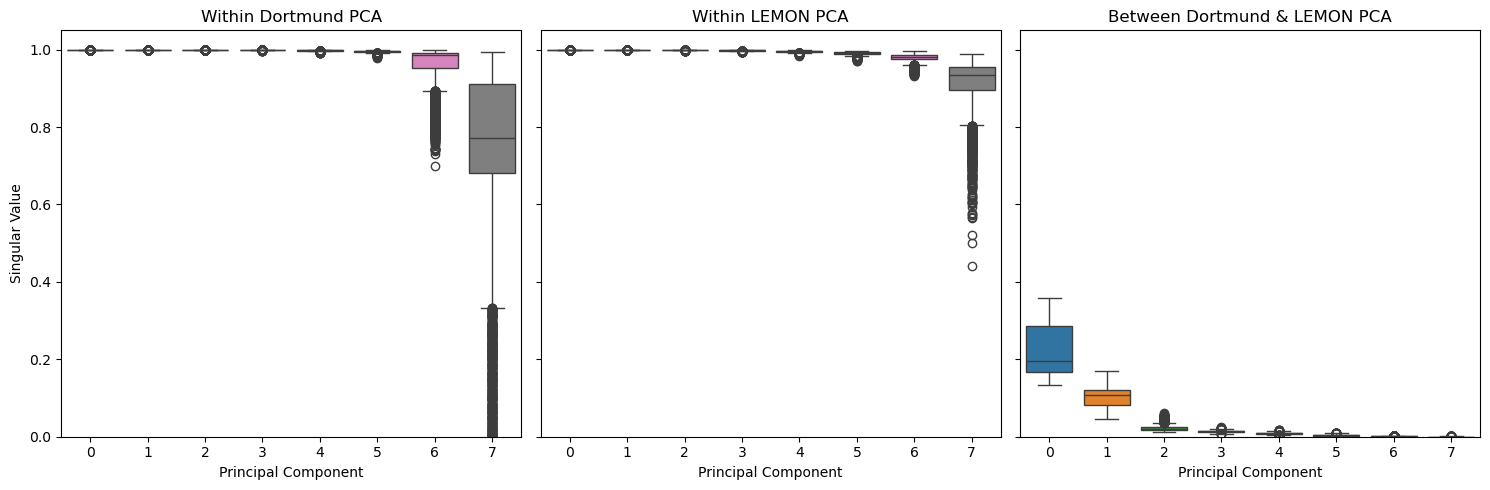

In [51]:
def summarize_bootstrap_results_subplots(results_dicts, titles):
    """
    Plot multiple bootstrap singular value boxplots in subplots.

    results_dicts: list of results dictionaries (e.g., [within_Dortmund, within_Lemon, between_DL])
    titles: list of subplot titles corresponding to each dictionary
    """
    n_plots = len(results_dicts)
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5), sharey=True)

    if n_plots == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, results_dict, title in zip(axes, results_dicts, titles):
        all_svals = np.array(list(results_dict.values()))
        sns.boxplot(data=all_svals, ax=ax)
        ax.set_xlabel("Principal Component")
        ax.set_title(title)
        ax.set_ylim(0,1.05)

        # Print mean singular values
        mean_svals = np.mean(all_svals, axis=0)
        print(f"{title} - Mean singular values per component:\n{mean_svals}\n")

    axes[0].set_ylabel("Singular Value")
    plt.tight_layout()
    plt.show()

# Call the function
summarize_bootstrap_results_subplots(
    [results["within_Dortmund"], results["within_Lemon"], results["between_DL"]],
    ["Within Dortmund PCA", "Within LEMON PCA", "Between Dortmund & LEMON PCA"]
)


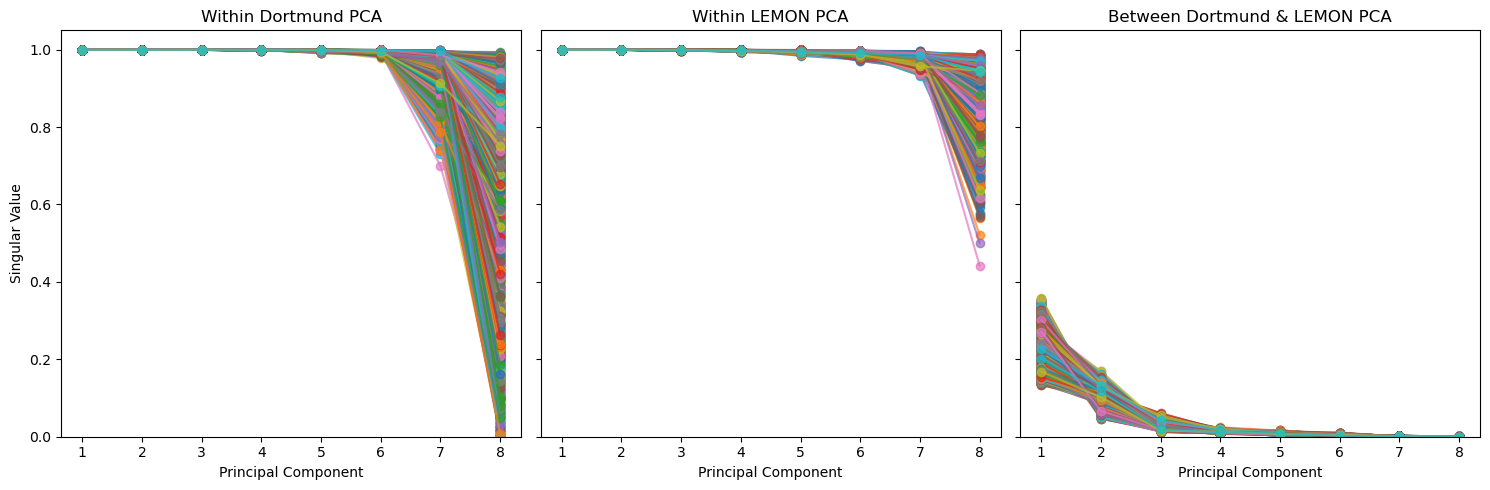

In [46]:
def lineplot_bootstrap_subplot(results_dicts, titles):
    """
    Plot multiple bootstrap singular value lineplots in subplots.

    results_dicts: list of results dictionaries (e.g., [within_Dortmund, within_Lemon, between_DL])
    titles: list of subplot titles corresponding to each dictionary
    """
    n_plots = len(results_dicts)
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5), sharey=True)

    if n_plots == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, results_dict, title in zip(axes, results_dicts, titles):
        all_svals = np.array(list(results_dict.values()))
        for svals in all_svals:
            ax.plot(range(1, len(svals)+1), svals, marker='o', alpha=0.7)
        ax.set_xlabel("Principal Component")
        ax.set_title(title)
        ax.set_ylim(0,1.05)

    axes[0].set_ylabel("Singular Value")  # Only left-most plot needs y-axis label
    plt.tight_layout()
    plt.show()

# Call the function with your results
lineplot_bootstrap_subplot(
    [results["within_Dortmund"], results["within_Lemon"], results["between_DL"]],
    ["Within Dortmund PCA", "Within LEMON PCA", "Between Dortmund & LEMON PCA"]
)


In [43]:
def summary_table_all(results_dicts, labels):
    import pandas as pd
    for results_dict, label in zip(results_dicts, labels):
        all_svals = np.array(list(results_dict.values()))
        mean_svals = np.mean(all_svals, axis=0)
        std_svals = np.std(all_svals, axis=0)
        df = pd.DataFrame({
            "Component": range(1, len(mean_svals)+1),
            "Mean Singular Value": mean_svals,
            "Std Dev": std_svals
        })
        print(f"\nSummary for {label}:\n")
        display(df)

summary_table_all(
    [results["within_Dortmund"], results["within_Lemon"], results["between_DL"]],
    ["Within Dortmund", "Within LEMON", "Between Dortmund & LEMON"]
)



Summary for Within Dortmund:



,Component,Mean Singular Value,Std Dev
0,1,0.999989,0.000006
1,2,0.999931,0.000043
2,3,0.999811,0.000102
3,4,0.999452,0.000297
4,5,0.998297,0.000927
5,6,0.995774,0.002280
6,7,0.962904,0.048481
7,8,0.744930,0.209418



Summary for Within LEMON:



,Component,Mean Singular Value,Std Dev
0,1,0.999974,0.000014
1,2,0.999804,0.000105
2,3,0.999149,0.000362
3,4,0.997993,0.000772
4,5,0.995704,0.001646
5,6,0.991094,0.003484
6,7,0.980018,0.008725
7,8,0.915502,0.061471



Summary for Between Dortmund & LEMON:



,Component,Mean Singular Value,Std Dev
0,1,0.218121,0.059528
1,2,0.102150,0.023591
2,3,0.022317,0.006494
3,4,0.013925,0.002245
4,5,0.008733,0.002083
5,6,0.003635,0.001639
6,7,0.000720,0.000304
7,8,0.000196,0.000142


### PCA Stability and Cross-Dataset Comparison (Summary)

- **Within Dortmund:** Principal components are highly stable across bootstrap samples (singular values ≈ 0.98–0.999). PCA subspace is robust and reproducible.
- **Within LEMON:** Components are stable overall, though the least dominant components vary slightly more (singular values ≈ 0.64–0.99).
- **Between Dortmund and LEMON:** Singular values are very low (≈ 0.0001–0.25), indicating that PCA subspaces are dataset-specific and not shared.

### Conclusion:
- PCA is reliable within each dataset but differs between datasets.
- The same PCA cannot be used for both Dortmund and LEMON, so downstream analyses (e.g., clustering) should be performed on PCA fitted separately to each dataset.

### Next Steps (Optional)
If desired, the bootstrap distributions can be further summarized by:

- KL-divergence between distributions  
- p-values for separability  
- violin/ridge plots for publication  
- cluster dendrograms based on similarity

## APPENDIX (IGNORE)

In [ ]:
"""--- JUST FOR PURPOSES OF SAVING IF THE PLOTS DONT WORK
# Fit PCA on standardized data (no limit on number of components now)
pca = PCA()
pca.fit_transform(dort_scaled)

# Explained variance ratio for each PC
normalised_values=pca.explained_variance_ratio_ 

# Cumulative explained variance as percentage
cumulative_sum = np.cumsum(normalised_values) * 100

# --- Automatic cutoff: number of PCs needed to reach 80% variance ---
threshold = 0.8  # 80% variance
num_pcs_threshold = np.argmax(np.cumsum(normalised_values) >= threshold) + 1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative variance plot
axes[0].plot(range(1, len(normalised_values)+1), cumulative_sum, marker='o', linestyle='-')
axes[0].axvline(x=num_pcs_threshold, color='r', linestyle='--', 
                label=f'80% Variance at PC{num_pcs_threshold}')
axes[0].set_xlabel("Number of Principal Components")
axes[0].set_ylabel("Cumulative Explained Variance (%)")
axes[0].set_title("Cumulative Explained Variance")
axes[0].grid(True)
axes[0].legend()

# Scree plot: variance explained by each PC
axes[1].plot(range(1, len(normalised_values)+1), normalised_values*100, marker='o', linestyle='-', alpha=0.7)
axes[1].axhline(y=normalised_values[num_pcs_threshold-1]*100, color='r', linestyle='--',
                label=f'Variance of PC{num_pcs_threshold}')
axes[1].legend()
axes[1].set_xlabel("Principal Component")
axes[1].set_ylabel("Explained Variance (%)")
axes[1].set_title("Scree Plot")
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Print the variance explained by the first principal component
print(f"Variance explained by the first PC: {normalised_values[0]*100:.2f}%")
print(f"Number of PCs needed to reach 80% variance: {num_pcs_threshold}")

"""

"""--- PCA with optimal number of components (n=16) ---
pca_optimal = PCA(n_components=16)
dort_pca_optimal = pca_optimal.fit_transform(dort_scaled)

print("=== Feature Space Size ===")
print(f"Original features: {dort.shape}")
print(f"PCA-reduced features: {dort_pca_optimal.shape}\n")

explained_variance_optimal = pca_optimal.explained_variance_ratio_
singular_values_optimal=pca_optimal.singular_values_
components_optimal = pca_optimal.components_

# Explained variance
print("=== Explained Variance Ratio (Each PC) ===")
for i, var in enumerate(explained_variance_optimal, start=1):
    print(f"PC{i}: {var*100:.2f}%")
print(f"Cumulative variance explained by first 2 PCs: {explained_variance_optimal[:2].sum()*100:.2f}%\n")

# Singular values
print("=== Singular Values (first 5) ===")
print(singular_values_optimal[:5], "\n")

# PCA Components (show first 3 features per PC for brevity)
print("=== PCA Components Loadings (first 3 features per PC) ===")
for i, pc in enumerate(components_optimal, start=1):
    print(f"PC{i}: {pc[:3]}")
"""

'--- PCA with optimal number of components (n=16) ---\npca_optimal = PCA(n_components=16)\ndort_pca_optimal = pca_optimal.fit_transform(dort_scaled)\n\nprint("=== Feature Space Size ===")\nprint(f"Original features: {dort.shape}")\nprint(f"PCA-reduced features: {dort_pca_optimal.shape}\n")\n\nexplained_variance_optimal = pca_optimal.explained_variance_ratio_\nsingular_values_optimal=pca_optimal.singular_values_\ncomponents_optimal = pca_optimal.components_\n\n# Explained variance\nprint("=== Explained Variance Ratio (Each PC) ===")\nfor i, var in enumerate(explained_variance_optimal, start=1):\n    print(f"PC{i}: {var*100:.2f}%")\nprint(f"Cumulative variance explained by first 2 PCs: {explained_variance_optimal[:2].sum()*100:.2f}%\n")\n\n# Singular values\nprint("=== Singular Values (first 5) ===")\nprint(singular_values_optimal[:5], "\n")\n\n# PCA Components (show first 3 features per PC for brevity)\nprint("=== PCA Components Loadings (first 3 features per PC) ===")\nfor i, pc in enu

### EXPORT DATA AS CSV FILES (ORIGINAL EXPORTING JUST TO SAVE IF FUNCTION PRODUCES DIFFERENT RESULTS)

In [ ]:
"""
# --- PCA Components (Loadings) ---
# Rows = PCs, Columns = original features
# This shows HOW MUCH each original feature contributes to each PC
components_df = pd.DataFrame(
    components_optimal,
    columns=dort_numeric.columns
)
components_df.index = [f'PC{i+1}' for i in range(components_df.shape[0])]
components_df.to_csv("dataset/Dortmund_pca_loadings.csv", index=True)
print("✓ PCA loadings exported to dataset/Dortmund_pca_loadings.csv")

# --- PCA Transformed Data ---
# Rows = Subjects, Columns = PCs
# This is what you use for CLUSTERING
transformed_df = pd.DataFrame(
    dort_pca_optimal,
    index=dort.index,  # Keep original subject IDs!
    columns=[f'PC{i+1}' for i in range(dort_pca_optimal.shape[1])]
)
transformed_df.to_csv("dataset/Dortmund_pca.csv", index=True)
print("✓ PCA transformed data exported to dataset/Dortmund_pca.csv")
print(f"  Subject IDs preserved: {transformed_df.index[:3].tolist()}... (first 3)")
"""

'\n# --- PCA Components (Loadings) ---\n# Rows = PCs, Columns = original features\n# This shows HOW MUCH each original feature contributes to each PC\ncomponents_df = pd.DataFrame(\n    components_optimal,\n    columns=dort_numeric.columns\n)\ncomponents_df.index = [f\'PC{i+1}\' for i in range(components_df.shape[0])]\ncomponents_df.to_csv("dataset/Dortmund_pca_loadings.csv", index=True)\nprint("✓ PCA loadings exported to dataset/Dortmund_pca_loadings.csv")\n\n# --- PCA Transformed Data ---\n# Rows = Subjects, Columns = PCs\n# This is what you use for CLUSTERING\ntransformed_df = pd.DataFrame(\n    dort_pca_optimal,\n    index=dort.index,  # Keep original subject IDs!\n    columns=[f\'PC{i+1}\' for i in range(dort_pca_optimal.shape[1])]\n)\ntransformed_df.to_csv("dataset/Dortmund_pca.csv", index=True)\nprint("✓ PCA transformed data exported to dataset/Dortmund_pca.csv")\nprint(f"  Subject IDs preserved: {transformed_df.index[:3].tolist()}... (first 3)")\n'